<h1>
<font color="#ff2e2e">
CamScanner
</font>
</h1>

In [135]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

<h3><font color = "#079e05"> Utilities </font></h3>

In [177]:
def imshow(im):
    width, height, *channels = im.shape
    if channels:
        # By default, OpenCV tends to work with images in the BGR format.
        # This is due to some outdated practices, but it has been left in the library.
        # We can iterate the channels in reverse order to get an RGB image.
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im, cmap='gray')
    plt.axis('off')

In [178]:
def get_corners(approximations):
    
    # to work easier with it 
    all_corners = approximations[:,0]

    # get height of corners
    height_corners = all_corners[:,1]

    # maximum height is left bottom corner
    left_bottom = all_corners[np.argmax(height_corners)]

    #minimum height is left top corner
    left_top = all_corners[np.argmin(height_corners)]
    
    # points vertically near left corners are right corners 
    for corner in all_corners:
        if abs(corner[1]-left_bottom[1]) > 10 and abs(corner[1]-left_bottom[1]) < 600:
            right_bottom = corner
            break

    for corner in all_corners:
        if abs(corner[1]-left_top[1]) > 10 and abs(corner[1]-left_top[1]) < 600:
            right_top = corner
            break
    
    return [left_top, left_bottom, right_top, right_bottom]
    

<h3><font color = "#079e05"> Image </font></h3>

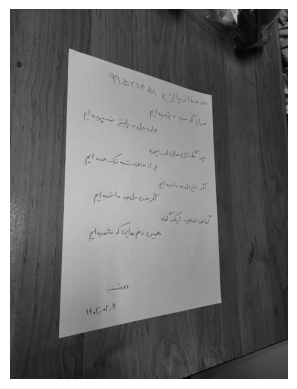

In [179]:
im = cv2.imread(os.path.join('images/Q4', '3.jpg'))
gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
imshow(gray_im)

<h3><font color = "#079e05"> Process </font></h3>

<h4><font color = "#079e05"> find edges </font></h4>

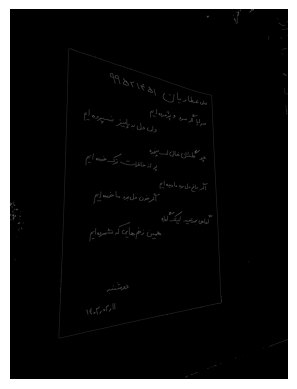

In [190]:
# denoising using bilateral filter
denoised_im = cv2.bilateralFilter(gray_im , 30 ,60, 50)

# apply canny 
canny_im = cv2.Canny(denoised_im, 60, 90)

# show edges
imshow(canny_im)

<h4><font color = "#079e05"> find the paper </font></h4>

5247


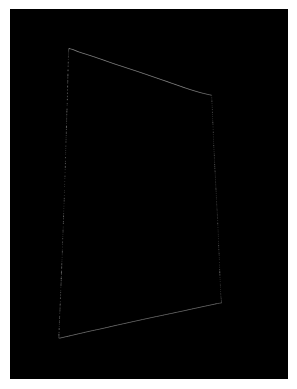

In [189]:
# find contours
contours, hierarchy = cv2.findContours(canny_im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# find the longest contour (it's paper)
max_contour = contours[0]
max_contour_len = len(max_contour)
for contour in contours:
    if max_contour_len < len(contour):
        max_contour = contour
        max_contour_len = len(contour)


# show the paper contour on a blank image
contours_image = np.zeros(canny_im.shape)
cv2.drawContours(contours_image, max_contour, -1, (255,255,255), 3)
imshow(contours_image)
print(len(max_contour))

<h4><font color = "#079e05"> get 4 corners </font></h4>

[636 426]
[ 528 3556]
[2176  932]
[2282 3175]


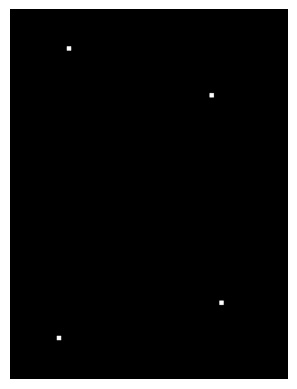

In [200]:
# get paper as a polyDP
epsilon = 0.05 * cv2.arcLength(max_contour, True)
approximations = cv2.approxPolyDP(max_contour, epsilon, True)

# get four corners
corners = get_corners(approximations)

# show these corners on a blank image
test_image = np.zeros(canny_im.shape)
for point in corners:
        # mark the corners
        print(point)
        cv2.drawMarker(test_image, tuple(point), (255,255,255), cv2.MARKER_STAR, 30, 20)
imshow(test_image)

<h4><font color = "#079e05"> apply transformation </font></h4>

[2282. 3556.]


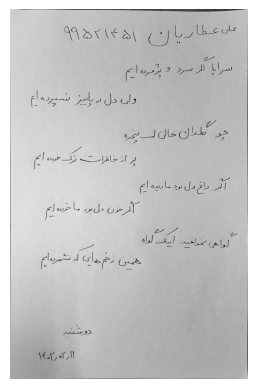

In [198]:
# make result shape similar to paper shape
paper_shape = np.max(corners, axis=0)
result_corners = np.float32([[0,0],[0,paper_shape[1]],[paper_shape[0],0],[paper_shape[0],paper_shape[1]]])

# to work with cv2.getPerspectiveTransform
paper_corners = np.float32(corners)

# get transform matrix
mat = cv2.getPerspectiveTransform(src = paper_corners, dst = result_corners)

# apply transformation
result = cv2.warpPerspective(gray_im, mat,(int(paper_shape[0]),int(paper_shape[1])))

# show transformed paper
imshow(result)

<h3><font color = "#079e05"> Show the result (bonus) </font></h3>

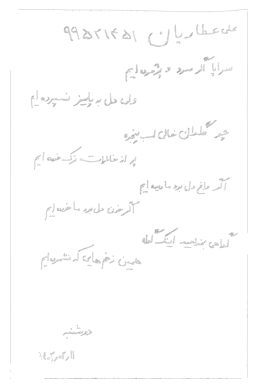

In [210]:
# use clahe to enhance contrast
clahe = cv2.createCLAHE(clipLimit=5)
clahe_res = clahe.apply(result)

# denoising
denoised_res = cv2.bilateralFilter(clahe_res , 20 ,70 ,60)

# apply canny
canny_res = cv2.Canny(denoised_res, 60, 90)

# to get white background
ret,th_res = cv2.threshold(canny_res,100,255,cv2.THRESH_BINARY_INV)

# show final result
imshow(th_res)
